<a href="https://colab.research.google.com/github/rikvik2006/MNIST-Challenge-PyTorch/blob/master/Definitivo_EMNIST_only_letter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EMINST CNN
Instanza Riccardo

In [1]:
#Import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import copy
from sklearn.model_selection import train_test_split

#for importing data
import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats("svg")

<ipython-input-1-11aeaf62c323>:17: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats("svg")


In [2]:
#Use GPU if aviabile
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("🖥️", device)

🖥️ cuda:0


#Import and inspect the data

In [3]:
#download the dataset
cdata = torchvision.datasets.EMNIST(root="emnist", split="letters", download=True)

100%|██████████| 561753746/561753746 [00:05<00:00, 105095430.45it/s]


Extracting emnist/EMNIST/raw/gzip.zip to emnist/EMNIST/raw


In [4]:
#inspect data

#the categories
print(cdata.classes)
print(f"{len(cdata.classes)} classes")

print("\nData size:")
print(cdata.data.shape)

#Transform to 4D tensor for convolutional layers
images = cdata.data.view([124800, 1, 28, 28]).float()
print("\nTensor data:")
print(images.shape)

['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
27 classes

Data size:
torch.Size([124800, 28, 28])

Tensor data:
torch.Size([124800, 1, 28, 28])


In [5]:
# class N/A does not exist in the data
# cdata.targets property return a tensor with data labels
print(torch.sum(cdata.targets == 0))       # if zero there are no un classified data
torch.unique(cdata.targets)

tensor(0)


tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26])

In [6]:
# Numeral class value
cdata.class_to_idx

{'N/A': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

## Rimoviamo la classe N/A dal dataset
Rimuoviamo la classe eseguendo uno slice del array dal elemento con indice uno.
Rimosso la classe adiamo a sottrare uno da ogni label, perché non esistendo più la classe N/A ora i label non sono più riallineati con gli indici

### Esempio
`[N/A, a, ..., y, z]`

```
{'N/A': 0,
 'a': 1,
  ...
 'y': 25,
 'z': 26}
 ```

 `[a, b, ..., y, z]`

```
{ 'a': 0,
 'b': 1,
  ...
 'y': 24,
 'z': 25}
 ```

In [7]:
# eliminate the N/A class and subtract 1 from the original

# remove the frist class category
letterCategories = cdata.classes[1: ]

print(cdata.targets)
# relabel labels to start at 0
labels = copy.deepcopy(cdata.targets) - 1   # Create a deep copy not a reference
print("⚪", labels.shape)

print("➕", torch.sum(labels == 0), "\tOra esistono 4800 lettere con label 0 ovvero delle \"a\"")
torch.unique(labels)

tensor([23,  7, 16,  ..., 13, 15, 19])
⚪ torch.Size([124800])
➕ tensor(4800) 	Ora esistono 4800 lettere con label 0 ovvero delle "a"


tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25])

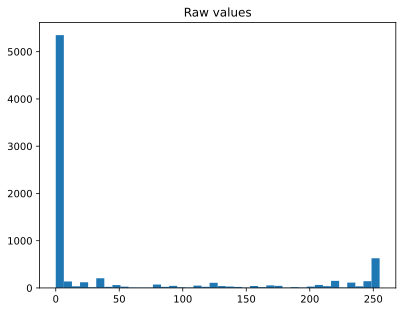

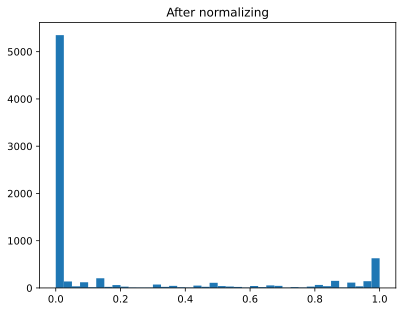

In [8]:
#Before normalising the images
plt.hist(images[:10, :, :, :].view(1, -1).detach(), 40)
plt.title("Raw values")
plt.show()

#Normalizing images
images /= torch.max(images)

#After normalising the images
plt.hist(images[:10, :, :, :].view(1, -1).detach(), 40)
plt.title("After normalizing")
plt.show()

# Creiamo una griglia di immagini
IMPORTANTE: La variable `I`, ovvero il tensore dell immagine deve essere permutata, con la proprietà `I.T` restituiamo il tesore ribaltato sulla sula diagonale, questo ruota l'imamgine di 45° verso destra

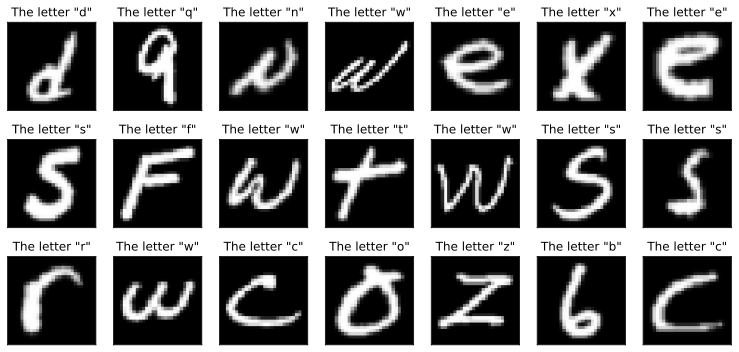

In [19]:
#Visualize some images
fig, axs = plt.subplots(3, 7, figsize=(13, 6))

for i, ax in enumerate(axs.flatten()):

    #pick a random pic
    whichpic = np.random.randint(images.shape[0])

    #extract the image and its target letter
    I = np.squeeze(images[whichpic, :, :])
    letter = letterCategories[labels[whichpic]]

    #visualize
    ax.imshow(I.T, cmap="gray")   # I.T read above IMPORTANT
    ax.set_title(f"The letter \"{letter}\"")
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

#Create train/test groups using DataLoader

In [10]:
#use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(images, labels, test_size=.1)

#Convert into Pytorch Datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

#translate into dataloader objects
batchsize = 32
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [11]:
#check size (should be image X channel X width X height)
print(train_loader.dataset.tensors[0].shape)
print(train_loader.dataset.tensors[1].shape)

torch.Size([112320, 1, 28, 28])
torch.Size([112320])


#Creating the Model

In [12]:
from sqlalchemy.sql.expression import false
#Crate a class for the model
def makeTheNet(printtoggle=False):

    class emnistnet(nn.Module):
        def __init__(self, printtoggle, *args, **kwargs) -> None:
            super().__init__(*args, **kwargs)

            #print toggle
            self.print = printtoggle

            ### __________ feature map layers __________ ###
            #Frist convolutional layer
            self.conv1 = nn.Conv2d(1, 6, 3, padding=1)
            self.bnorm1 = nn.BatchNorm2d(6) #input the number of channels in this layer
            #output size: (28 + 2*1 - 3)/1 + 1 = 28/2 = 14 (/2 b/c maxpool)

            #Second convolutional layer
            self.conv2 = nn.Conv2d(6, 6, 3, padding=1)
            self.bnorm2 = nn.BatchNorm2d(6) #input the number of channels in this layer
            #output size: (14 + 2*1 - 3)/1 + 1 = 14/2 = 7 (/2 b/c maxpool)


            ### __________ linear decision layer __________ ###
            self.fc1 = nn.Linear(7*7*6, 50)
            self.fc2 = nn.Linear(50, 26)

        def forward(self, x):

            if self.print:
                print(f"Input: {list(x.shape)}")

            #Frist block: convolutional => maxpoll => batchnorm => relu
            x = F.max_pool2d(self.conv1(x), 2)
            x = F.leaky_relu(self.bnorm1(x))
            if self.print:
                print(f"Frist CPR block: {list(x.shape)}")

            #Second block: convolutional => maxpoll => batchnorm => relu
            x = F.max_pool2d(self.conv2(x), 2)
            x = F.leaky_relu(self.bnorm2(x))
            if self.print:
                print(f"Second CPR block: {list(x.shape)}")

            #Repshape for linear layer
            nUnits = x.shape.numel() / x.shape[0]
            x = x.view(-1, int(nUnits))
            if self.print:
                print(f"Vectorized: {list(x.shape)}")

            #Linear layers
            x = F.leaky_relu(self.fc1(x))
            x = self.fc2(x)
            if self.print:
                print(f"Final output: {list(x.shape)}")

            return x

    #Create the model instance
    net = emnistnet(printtoggle)

    #loss function
    lossfun = nn.CrossEntropyLoss()

    #optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=.001)

    return net, lossfun, optimizer


In [13]:
#test the model
net, lossfun, optimizer = makeTheNet(True)
x, y = iter(train_loader).__next__()
yHat = net(x)

#check size of output
print("\nOutput size:")
print(yHat.shape)

#compute the loss
loss = lossfun(yHat, torch.squeeze(y))
print(' ')
print('Loss:')
print(loss)

Input: [32, 1, 28, 28]
Frist CPR block: [32, 6, 14, 14]
Second CPR block: [32, 6, 7, 7]
Vectorized: [32, 294]
Final output: [32, 26]

Output size:
torch.Size([32, 26])
 
Loss:
tensor(3.2832, grad_fn=<NllLossBackward0>)


#Train the model

In [14]:
# a function that trains the model

def function2trainTheModel():

    #number of epochs
    numepochs = 10

    #create a new model
    net, lossfun, optimizer = makeTheNet()

    #send the model to the GPU
    net.to(device)

    #initialize losses
    trainLoss = torch.zeros(numepochs)
    testLoss = torch.zeros(numepochs)
    trainErr = torch.zeros(numepochs)
    testErr = torch.zeros(numepochs)

    #loop over epochs
    for indexEpoch in range(numepochs):

        #loop over trainig data batches
        net.train()
        batchLoss = []
        batchErr = []
        for images, labels in train_loader:

            #push data to GPU
            images = images.to(device)
            labels = labels.to(device)

            #forward pass and loss
            labelsHat = net(images)
            loss = lossfun(labelsHat, labels)

            #backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #loss and error from this batch
            batchLoss.append(loss.item())
            batchErr.append(torch.mean((torch.argmax(labelsHat, axis=1) != labels).float()).item())
        #end of the batch loop

        #get average losses and error  rates across the batches
        trainLoss[indexEpoch] = np.mean(batchLoss)
        trainErr[indexEpoch] = 100 * np.mean(batchErr)

        #test performance
        net.eval()
        images, labels = next(iter(test_loader))  #extract images, labels from the test loader

        #push data to GPU
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():   #deactivate autograd
            labelsHat = net(images)
            loss = lossfun(labelsHat, labels)

        #get loss and error rate from the test batch
        testLoss[indexEpoch] = loss.item()
        testErr[indexEpoch] = 100 * torch.mean((torch.argmax(labelsHat, axis=1) != labels).float()).item()

    #end epochs

    #function output
    return trainLoss, testLoss, trainErr, testErr, net

#Run the model and show the result

In [15]:
trainLoss, testLoss, trainErr, testErr, net = function2trainTheModel()

# Salvare i pesi dei modelli

In [20]:
weight_version = 0

In [21]:
# Salva i pesi del modello in un file (cwd: /content)
weight_version += 1
torch.save(net.state_dict(), f'EMNIST_model_weights_CNN_definitivo.pth.v{weight_version}')
print("Pesi del modello salvati.")

Pesi del modello salvati.


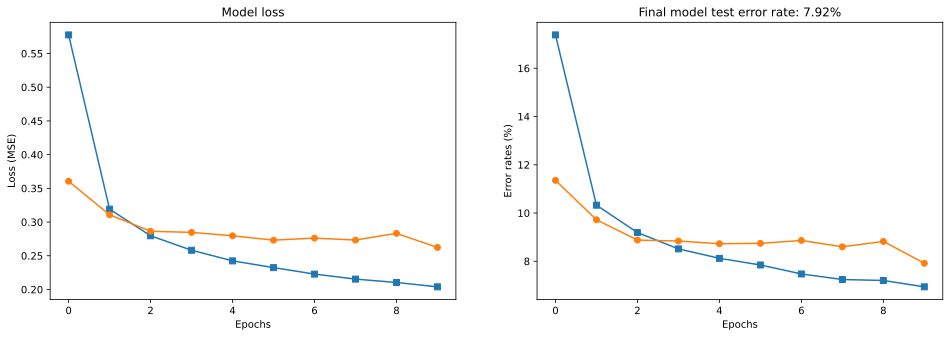

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(trainLoss, 's-', label="Train")
ax[0].plot(testLoss, 'o-', label="Test")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss (MSE)")
ax[0].set_title("Model loss")

ax[1].plot(trainErr, "s-", label="Train")
ax[1].plot(testErr, "o-", label="Test")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Error rates (%)")
ax[1].set_title(f"Final model test error rate: {testErr[-1]:.2f}%")

plt.show()

#Visualize some images

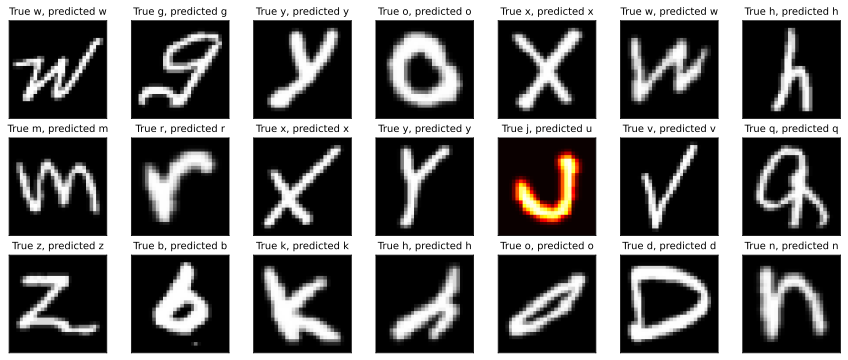

In [23]:
#extract x, y from test dataloader
x, y = next(iter(test_loader))
x = x.to(device)    #push data to GPU
y = y.to(device)    #push data to GPU
yHat = net(x)

#pick some examples at random to show
randex = np.random.choice(len(y), size=21, replace=False)

#visualize some images
fig, axs = plt.subplots(3, 7, figsize=(15, 6))

for i, ax in enumerate(axs.flatten()):

    #extract the image and its target letter
    I = np.squeeze(x[randex[i], 0, :, :]).cpu() #.cpu() to transfer back from GPU
    trueLetter = letterCategories[y[randex[i]]]
    predLetter = letterCategories[torch.argmax(yHat[randex[i], :])]

    #color-code the accuracy (using ternary operator)
    col = "gray" if trueLetter == predLetter else "hot"

    #visualize
    ax.imshow(I.T, cmap=col)
    ax.set_title(f"True {trueLetter}, predicted {predLetter}", fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

#Accuracy by letter

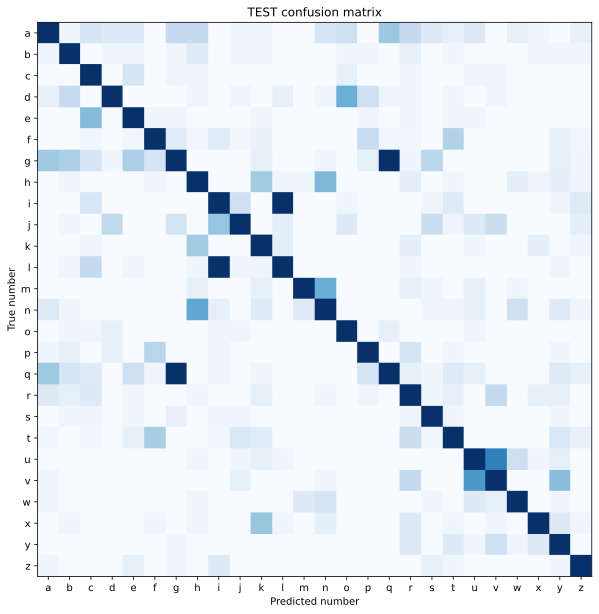

In [18]:
import sklearn.metrics as skm

#compute the confusion matrix
C = skm.confusion_matrix(y.cpu(), torch.argmax(yHat.cpu(), axis=1), normalize="true")

#visualize
fig = plt.figure(figsize=(10, 10))
plt.imshow(C, "Blues", vmax=.05)

#make the plot look nicer
plt.xticks(range(26), labels=letterCategories)
plt.yticks(range(26), labels=letterCategories)
plt.title("TEST confusion matrix")
plt.xlabel("True number")
plt.xlabel("Predicted number")
plt.ylabel("True number")

plt.show()

# Test con immagini custom

In [24]:
from PIL import Image
import PIL.ImageOps

In [25]:
def prepareTheImage(image: Image, invert=False) -> Image:
  image = image.resize((28, 28)).convert("L")
  if invert:
    image = PIL.ImageOps.invert(image)

  plt.imshow(image)

  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.5,), (0.5,)),
  ])

  image = transform(image).unsqueeze(0)

  # image = np.array(image)
  # image = image / np.max(image)
  # image = torch.from_numpy(image)
  # image = image.float()
  image = image.to(device)

  return image

In [26]:
def predictImage(image: Image) -> str:
  net.eval()

  with torch.no_grad():
    result = net.forward(image)
    predicted_letter = letterCategories[torch.argmax(result)]

  return predicted_letter

Predicted letter: w


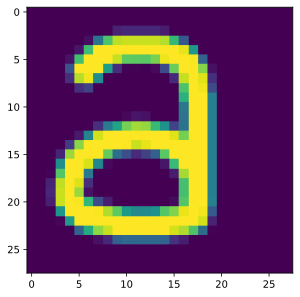

In [ ]:
image = Image.open("imgTestA.png")

image = prepareTheImage(image, invert=True)
predict = predictImage(image)

print("Predicted letter:", predict)